<a href="https://colab.research.google.com/github/Khislatz/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/Khislat_Zhuraeva_LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [1]:
from zipfile import ZipFile 
file_name = "/content/credit-card-approval-prediction.zip"
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
    # extracting all the files 
    zip.extractall() 


File Name                                             Modified             Size
application_record.csv                         2020-03-24 10:05:00     54342959
credit_record.csv                              2020-03-24 10:05:02     15367102


In [2]:
import pandas as pd
import numpy as np
application_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')
application_df.shape, credit_df.shape

((438557, 18), (1048575, 3))

In [3]:
credit_approval_df = pd.merge(credit_df, application_df)
credit_approval_df.shape

(777715, 20)

In [0]:
# credit_approval_df = credit_approval_df.drop_duplicates(inplace=False)

In [0]:
credit_approval_df.rename(columns = {'ID':'ID', 'MONTH_BALANCE':'MONTH_BALANCE', 
                              'STATUS':'STATUS','CODE_GENDER':'GENDER', 
                              'FLAG_OWN_CAR':'OWN_CAR', 'FLAG_OWN_REALTY':'OWN_REALTY',
                              'CNT_CHILDREN':'CHILDREN', 'AMT_INCOME_TOTAL':'ANNUAL_INCOME',
                              'NAME_INCOME_TYPE':'INCOME_CATEGORY', 
                              'NAME_EDUCATION_TYPE':'EDUCATION_LEVEL',
                              'NAME_FAMILY_STATUS':'MARITAL_STATUS',
                              'NAME_HOUSING_TYPE':'HOUSING_TYPE',
                              'DAYS_EMPLOYED':'START_DATE_OF_EMPLOYMENT',
                              'FLAG_MOBIL':'CELL_PHONE', 
                              'FLAG_WORK_PHONE': 'WORK_PHONE',
                              'FLAG_EMAIL':'EMAIL', 
                              'CNT_FAM_MEMBERS': 'FAMILY_MEMBERS'}, inplace = True)

In [6]:
credit_approval_df.head()

,ID,MONTHS_BALANCE,STATUS,GENDER,OWN_CAR,OWN_REALTY,CHILDREN,ANNUAL_INCOME,INCOME_CATEGORY,EDUCATION_LEVEL,MARITAL_STATUS,HOUSING_TYPE,DAYS_BIRTH,START_DATE_OF_EMPLOYMENT,CELL_PHONE,WORK_PHONE,FLAG_PHONE,EMAIL,OCCUPATION_TYPE,FAMILY_MEMBERS
0,5008804,0,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008804,-1,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008804,-2,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
3,5008804,-3,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
4,5008804,-4,C,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0


In [7]:
credit_approval_df.isnull().sum()

ID                               0
MONTHS_BALANCE                   0
STATUS                           0
GENDER                           0
OWN_CAR                          0
OWN_REALTY                       0
CHILDREN                         0
ANNUAL_INCOME                    0
INCOME_CATEGORY                  0
EDUCATION_LEVEL                  0
MARITAL_STATUS                   0
HOUSING_TYPE                     0
DAYS_BIRTH                       0
START_DATE_OF_EMPLOYMENT         0
CELL_PHONE                       0
WORK_PHONE                       0
FLAG_PHONE                       0
EMAIL                            0
OCCUPATION_TYPE             240048
FAMILY_MEMBERS                   0
dtype: int64

In [8]:
# Get Pandas Profiling Report
from pandas_profiling import ProfileReport
profile = ProfileReport(credit_approval_df, minimal=True).to_notebook_iframe()
profile

In [9]:
#baseline 
target = 'STATUS'
credit_approval_df[target].value_counts(normalize=True)

C    0.423723
0    0.373728
X    0.187665
1    0.011247
5    0.001963
2    0.001030
3    0.000368
4    0.000275
Name: STATUS, dtype: float64

In [10]:
baseline = [credit_approval_df[target].mode()[0]]*len(credit_approval_df)
from sklearn.metrics import accuracy_score
accuracy_score(baseline, credit_approval_df[target])

0.4237233433841446

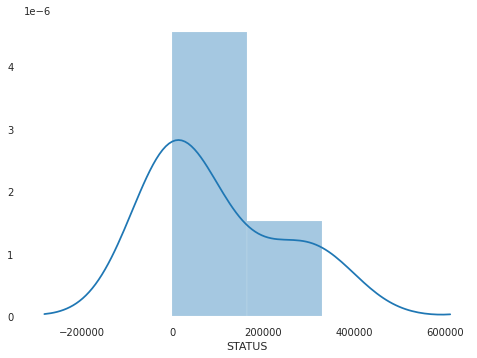

In [11]:
import seaborn as sns
y = credit_approval_df[target].value_counts()
sns.distplot(y);

In [12]:
corr_matrix = credit_approval_df.corr()
corr_matrix

,ID,MONTHS_BALANCE,CHILDREN,ANNUAL_INCOME,DAYS_BIRTH,START_DATE_OF_EMPLOYMENT,CELL_PHONE,WORK_PHONE,FLAG_PHONE,EMAIL,FAMILY_MEMBERS
ID,1.000000,0.005007,0.026269,-0.027597,0.042020,-0.025322,NaN,0.084800,0.006346,-0.056083,0.027375
MONTHS_BALANCE,0.005007,1.000000,0.000913,0.001831,0.035756,-0.004222,NaN,0.001529,-0.005120,0.005288,-0.006276
CHILDREN,0.026269,0.000913,1.000000,0.039304,0.356177,-0.228945,NaN,0.042226,-0.018882,0.015726,0.892079
ANNUAL_INCOME,-0.027597,0.001831,0.039304,1.000000,0.081231,-0.180674,NaN,-0.021229,0.018687,0.085776,0.031379
DAYS_BIRTH,0.042020,0.035756,0.356177,0.081231,1.000000,-0.608856,NaN,0.180658,-0.026717,0.100945,0.327750
START_DATE_OF_EMPLOYMENT,-0.025322,-0.004222,-0.228945,-0.180674,-0.608856,1.000000,NaN,-0.243677,-0.013817,-0.082474,-0.227645
CELL_PHONE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WORK_PHONE,0.084800,0.001529,0.042226,-0.021229,0.180658,-0.243677,NaN,1.000000,0.312552,-0.037991,0.060183
FLAG_PHONE,0.006346,-0.005120,-0.018882,0.018687,-0.026717,-0.013817,NaN,0.312552,1.000000,0.011901,-0.007824
EMAIL,-0.056083,0.005288,0.015726,0.085776,0.100945,-0.082474,NaN,-0.037991,0.011901,1.000000,0.012540


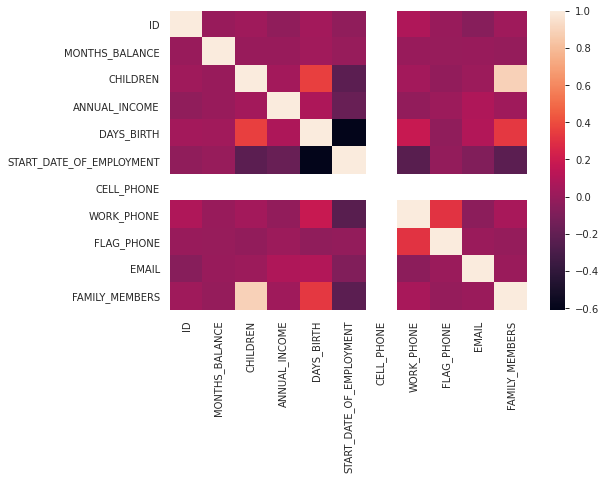

In [13]:
sns.heatmap(credit_approval_df.corr());

In [14]:
cardinality = credit_approval_df.select_dtypes(exclude='number').nunique()
high_cardinality_feat = cardinality[cardinality > 30].index.tolist()
high_cardinality_feat
#No high cardinality features

[]

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(credit_approval_df, train_size=0.80, test_size=0.20, 
                              stratify=credit_approval_df['STATUS'], random_state=42)

train.shape, test.shape

((622172, 20), (155543, 20))

In [16]:
train, val = train_test_split(train, train_size = 0.8, test_size = 0.2, 
                              stratify=train[target], random_state=42)
train.shape, test.shape, val.shape

((497737, 20), (155543, 20), (124435, 20))

In [17]:
train.head()

,ID,MONTHS_BALANCE,STATUS,GENDER,OWN_CAR,OWN_REALTY,CHILDREN,ANNUAL_INCOME,INCOME_CATEGORY,EDUCATION_LEVEL,MARITAL_STATUS,HOUSING_TYPE,DAYS_BIRTH,START_DATE_OF_EMPLOYMENT,CELL_PHONE,WORK_PHONE,FLAG_PHONE,EMAIL,OCCUPATION_TYPE,FAMILY_MEMBERS
242946,5051094,-9,C,M,Y,N,0,360000.0,Commercial associate,Incomplete higher,Married,House / apartment,-11171,-2053,1,1,0,0,Managers,2.0
349386,5067218,-14,0,F,N,Y,1,166500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-12258,-1816,1,0,0,1,NaN,3.0
661523,5126527,-40,C,F,N,N,0,225000.0,State servant,Secondary / secondary special,Married,With parents,-12269,-196,1,0,1,0,Medicine staff,2.0
607725,5116971,-16,0,F,N,Y,2,157500.0,Commercial associate,Higher education,Married,House / apartment,-14975,-187,1,0,0,0,NaN,4.0
558481,5113317,-25,C,F,Y,Y,0,153000.0,Working,Secondary / secondary special,Married,House / apartment,-19503,-10147,1,0,0,1,High skill tech staff,2.0


In [18]:
def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    X.drop_duplicates(inplace=True)
    # X = X.drop(['OCCUPATION_TYPE', 'DAYS_BIRTH'], axis=1)
    # Prevent SettingWithCopyWarning
    X = X.copy()
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
train.shape, test.shape, val.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


((497737, 20), (155543, 20), (124435, 20))

In [0]:
target = 'STATUS'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [20]:
credit_approval_df['OWN_CAR'].replace({'N': 0, 'Y': 1})
credit_approval_df['OWN_REALTY'].replace({'N': 0, 'Y': 1})

0         1
1         1
2         1
3         1
4         1
         ..
777710    0
777711    0
777712    0
777713    0
777714    0
Name: OWN_REALTY, Length: 777715, dtype: int64

In [21]:
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*

In [0]:
# import plotly.express as px
# fig = px.scatter(train, x="ANNUAL_INCOME", y="STATUS")
# fig.show()

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [24]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
     SimpleImputer(strategy='median'), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['GENDER', 'OWN_CAR', 'OWN_REALTY',
                                      'INCOME_CATEGORY', 'EDUCATION_LEVEL',
                                      'MARITAL_STATUS', 'HOUSING_TYPE',
                                      'OCCUPATION_TYPE'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'GENDER',
                                          'data_type': dtype('O'),
                                          'mapping': M      1
F      2
NaN   -2
dtype: int64},
                                         {'col': 'OWN_CAR',...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                              

In [25]:
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_val)
print(f'Val accuracy: {accuracy_score(y_val, y_pred)}')

Val accuracy: 0.4879495318841162


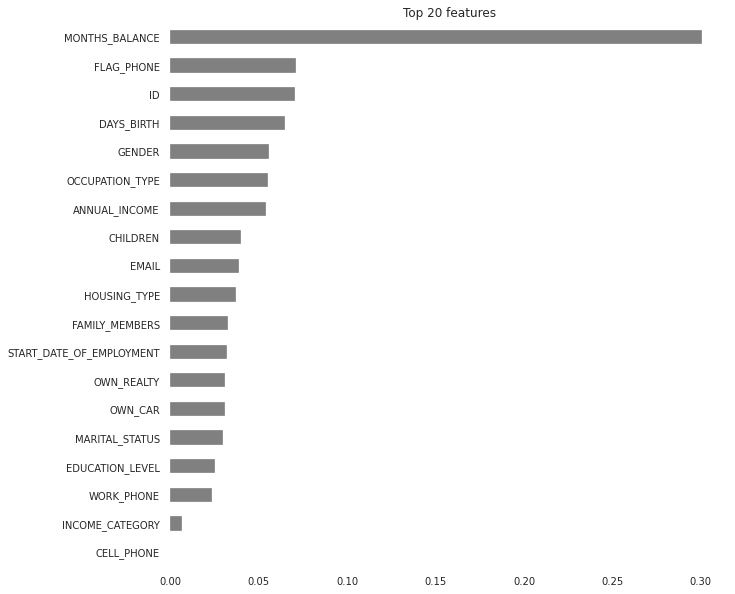

In [27]:
# Get feature importances
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [33]:
column  = 'MONTHS_BALANCE'

# Fit without column
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
     SimpleImputer(strategy='median'), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')


# Fit with column
pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
     SimpleImputer(strategy='median'), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without MONTHS_BALANCE: 0.4538996263109254
Validation Accuracy with MONTHS_BALANCE: 0.4879495318841162
Drop-Column Importance for MONTHS_BALANCE: 0.03404990557319082


In [34]:
# BEFORE: sequence of the feature to be permuted
feature = 'MONTHS_BALANCE'
X_val[feature].head()

440367   -49
681908    -6
714520   -38
752970   -36
233247    -5
Name: MONTHS_BALANCE, dtype: int64

In [35]:
# BEFORE: distribution of the feature to be permuted
X_val[feature].value_counts()

-2     4031
 0     3974
-1     3913
-4     3865
-3     3844
       ... 
-56     258
-57     197
-58     136
-59     103
-60      52
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [36]:
# PERMUTE!

X_val_permuted = X_val.copy()
X_val_permuted[feature] = np.random.permutation(X_val[feature])
X_val_permuted[feature].head()

440367   -16
681908    -4
714520     0
752970   -10
233247   -33
Name: MONTHS_BALANCE, dtype: int64

In [37]:
X_val_permuted[feature].value_counts()

-2     4031
 0     3974
-1     3913
-4     3865
-3     3844
       ... 
-56     258
-57     197
-58     136
-59     103
-60      52
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [38]:
score_permuted = pipeline.score(X_val_permuted, y_val)
print(f'Validation acc with {feature}: {score_with}')
print(f'Validation acc with {feature} permuted: {score_permuted}')
print(f'Permutation importance: {score_with - score_permuted}')

Validation acc with MONTHS_BALANCE: 0.4879495318841162
Validation acc with MONTHS_BALANCE permuted: 0.4277172821151605
Permutation importance: 0.06023224976895569
